# Decision Networks

In [1]:
using BayesNets
using DataFrames

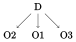

In [2]:
b = BayesNet([:D, :O1, :O2, :O3])
addEdges!(b, [(:D, :O1), (:D, :O2), (:D, :O3)])
setCPD!(b, :D, CPDs.Bernoulli(0.01))
setCPD!(b, :O1, CPDs.Bernoulli(a->(a[:D] ? 0.5 : 0.5))) # no real signal of whether disease is present
setCPD!(b, :O2, CPDs.Bernoulli(a->(a[:D] ? 0.9 : 0.01))) 
setCPD!(b, :O3, CPDs.Bernoulli(a->(a[:D] ? 0.6 : 0.3)))
b

In [3]:
U = DataFrame()
U[:T] = [false, false, true, true]
U[:D] = [false, true, false, true]
U[:U] = [0, -10, -1, -1]
U

,T,D,U
1,false,false,0
2,false,true,-10
3,true,false,-1
4,true,true,-1


In [4]:
function BayesNets.estimate(b::BayesNet, node::NodeName, a::Assignment; numSamples = 10000)
    srand(0)
    t = estimate(randTableWeighted(b, numSamples=numSamples, consistentWith=a))
    normalize(sumout(t, setdiff(b.names, [node])))
end;

In [5]:
D = estimate(b, :D, [:O1=>true])

,D,p
1,false,0.9899
2,true,0.010100000000000033


In [6]:
EU = join(U, D, on = :D)

,T,D,U,p
1,false,false,0,0.9899
2,true,false,-1,0.9899
3,false,true,-10,0.010100000000000033
4,true,true,-1,0.010100000000000033


In [7]:
by(EU, :T, df->dot(df[:U], df[:p]))

,T,x1
1,false,-0.10100000000000033
2,true,-1.0


In [8]:
function diseaseEU(b::BayesNet, a::Assignment, U::DataFrame)
    D = estimate(b, :D, a)
    EU = join(U, D, on = :D)
    t = by(EU, :T, df->dot(df[:U], df[:p]))
    rename!(t, :x1, :EU)
    t
end;

In [9]:
diseaseEU(b, [:O1=>true], U)

,T,EU
1,false,-0.10100000000000033
2,true,-1.0


In [10]:
diseaseEU(b, [:O1=>false], U)

,T,EU
1,false,-0.10100000000000033
2,true,-1.0


In [11]:
diseaseEU(b, [:O2=>true], U)

,T,EU
1,false,-4.786981936910852
2,true,-1.0


In [12]:
t = diseaseEU(b, [:O3=>true], U)

,T,EU
1,false,-0.19998019998019936
2,true,-1.0
